# Stochastic Simulation

*Winter Semester 2023/24*

10.11.2023

Prof. Sebastian Krumscheid<br>
Asstistant: Stjepan Salatovic

<h3 align="center">
Exercise sheet 02
</h3>

---

<h1 align="center">
Random Variable Generation
</h1>

In [4]:
import matplotlib.pylab as plt
import numpy as np
import time

from ipywidgets import interact
from scipy.integrate import quad
from scipy.stats import linregress
from scipy.stats import uniform, norm, expon, bernoulli, burr12
from typing import Callable, Optional, Tuple
from tqdm.notebook import tqdm

The following `cdf` function is the one you implemented in Lab 1 and you will need it later in this Lab, too.

In [5]:
def cdf(seq: np.array, x: np.array) -> np.array:
    """Computes the empirical CDF of `seq` and evaluates in `x`."""
    n = len(seq)
    indices = np.searchsorted(np.sort(seq), x, side='right')
    y = np.concatenate(([0], np.arange(1, n + 1) / n))
    return y[indices]

## Exercise 1

Consider the random variable $X$ with cumulative distribution function
(CDF) $F\colon[-1,3]\to [0,1]$ given by

\begin{equation*}
  F(x) = \begin{cases}
    0\;,& -1\le x<0\;,\\
    1-\frac{2}{3}e^{-x/2}\;,& 0\le x< 2\;,\\
    1\;,& 2\le x\le 3\;.
  \end{cases}
\end{equation*}

Implement the inverse-transform method to generate $n$ independent
copies of the random variable $X$. Assess the quality of the
realizations by comparing the empirical CDF with the theoretical CDF
$F$ for various values of $n$.

By direct computation of the generalized inverse

$$
F^{-1}(z) = \arg \inf \{x \in [-1,3] \mid F(x)\ge z\}
= \begin{cases}
  -1, & z=0\\
  0, &  z \in (0,1/3)\\
  -2\log(3(1-z)/2) & z \in [1/3, 1-2e^{-1}/3)\\
   2, & z \in [1-2e^{-1}/3,1]. 
  \end{cases}
$$

In [6]:
# Defines the cdf F and pdf f

F = lambda u: (u < 2) * (u >= 0) * (1 - 2 * np.exp(-u / 2.) / 3.) + (u >= 2) * (u <= 3)
f = lambda u: (u >= 0) * (u <= 2) * np.exp(- u / 2.) / 3.

In [7]:
# Defines the inverse cdf

intervalPoint = 1 - 2/3 * np.exp(-1)
invF = lambda u: (u < intervalPoint) * (u > 1./3.) * (-2 * np.log(3 * (1 - u) / 2.)) + 2 * (u > intervalPoint)

In [8]:
def inverse_transform(inv_cdf: Callable, n: int) -> np.array:
    """
    Generates sequence of `n` numbers using the inverse-transform method.
    """
    u = uniform.rvs(size=n)
    x = inv_cdf(u)
    return x

In [9]:
def plot_emp_cdf_vs_cdf(n: int):
    """Interaction helper."""
    seq = inverse_transform(invF, n)
    
    x = np.linspace(-1, 3, 10000)
    plt.plot(x, cdf(seq, x), label="Empirical CDF")
    plt.plot(x, F(x), label="Theoretical CDF")
    plt.xlabel(r"$x$")
    plt.ylabel("CDF")
    plt.legend()

Samples of $X$ may be generated by the inverse transform by $X_i = F^{-1}(U_i)$,
where $U_i \sim U([0,1])$. In the following interactive plot we compare the resulting
empirical CDF $F_n$ for different values of $n$ with the exact CDF of $X$.
Convergence is observed with the naked eye.

In [10]:
interact(plot_emp_cdf_vs_cdf, n=(10, 1000));

interactive(children=(IntSlider(value=505, description='n', max=1000, min=10), Output()), _dom_classes=('widge…

## Exercise 2

Consider the random variable $X$ with probability density function
(PDF) $f$, which is only known up a multiplicative
constant. Specifically, let $f(x) := k\tilde{f}(x)$ with

\begin{equation*}
  \tilde{f}(x) := \bigl(\sin^2(6x)+3\cos^2(x)\sin^2(4x)+1\bigr)e^{-x^2/2}\;,
\end{equation*}

where the normalization constant
$k = \left(\int_\mathbb{R}\tilde{f}(x)\,dx\right)^{-1}$ is unknown.

1. Argue that $\tilde{f}(x)$ can be bounded by $C\phi(x)$, where
  $C$ is an appropriately chosen constant and $\phi$ denotes the PDF
  of the standard normal distribution, that is
  $\phi(x) = e^{-x^2/2}/\sqrt{2\pi}$. Find an acceptable value for
  $C$.

A rough theoretical estimate for $C$ can be derived through observing that 
$$
\sup_{x \in \mathbb{R}} \sin(6x)^2+3\cos(x)^2\sin(4x)^2+1 \le 5,
$$
which implies that

$$
\sup_{x \in \mathbb{R}} \frac{\tilde{f}(x)}{\phi(x)} \le 5\sqrt{2\pi} =: \bar{C} \approx 12.53314.
$$

An improved estimate of $C$ can for instance be derived observing that
$$
\frac{\tilde f (x) }{\phi(x)} = \frac{\sin(6x)^2+3\cos(x)^2\sin(4x)^2+1}{\sqrt{2\pi}},
$$
which is a $\pi$-periodic function, whose maximimum, by inspection of the
plotted graph, is contained in the interval $x \in [0,0.5]$.
The maximum can be well approximated by using the built-in
`minimize` function within the module `scipy.optimize`.
This approach leads to $C=10.94031 < \bar C$, improving the efficiency of the
method sightly.

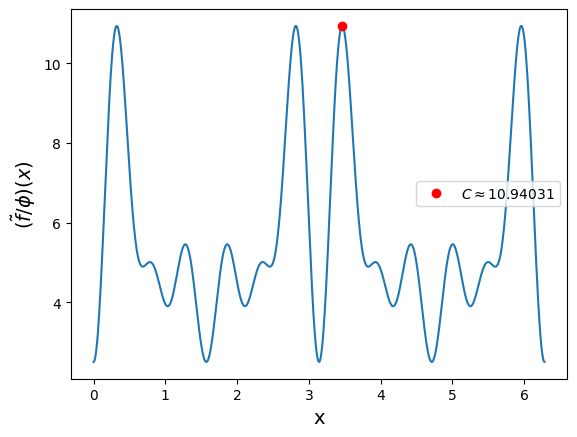

In [11]:
f = lambda u: (np.sin(6 * u) ** 2 + 3 * np.cos(u) ** 2 * np.sin(4 * u) ** 2 + 1.) * np.exp(-u ** 2 / 2.)
x = np.linspace(0, 2 * np.pi, 1000)

plt.plot(x, f(x) / norm.pdf(x))

ix = np.argmax(f(x) / norm.pdf(x))
plt.plot(x[ix], f(x[ix]) / norm.pdf(x[ix]), "ro", label=r"$C \approx 10.94031$")

plt.xlabel("x", size=14)
plt.ylabel(r"$(\tilde{f} / \phi)(x)$", size=14)
plt.legend();

2. Generate $n=10^4$ random variables according to the PDF $f$ using the Acceptance-Rejection Method. 

    **Hint:** Use `scipy.stats.norm.rvs()` to sample normally distributed random variables in **Python**.

In [12]:
def acceptance_rejection(n: int) -> Tuple[np.array, float]:
    """
    Generates sequence of `n` random numbers using the Acceptance-Rejection method.
    Returns the sequence as well as the acceptance rate.
    """
    C = 5 * np.sqrt(2 * np.pi)
    
    accs = []
    samples = []
    while len(samples) < n:
        x_props = norm.rvs(size=n)
        u = uniform.rvs(size=n)
        idx = u <= f(x_props) / norm.pdf(x_props) / C
        samples.extend(x_props[idx])
        samples = samples[:n] 
        accs.append(idx.sum())
    acc = np.mean(accs) / n

    return np.array(samples), acc

In [13]:
def interactive_hist(n: int):
    """Interaction helper."""
    samples, acc = acceptance_rejection(n)
    plt.hist(samples, bins=100, density=True);
    plt.ylim(0, 1);
    plt.xlim(-4, 4);
    plt.xlabel("$x$", size=14)
    plt.ylabel("Count", size=14)

interact(interactive_hist, n=(100, 10 ** 4));

interactive(children=(IntSlider(value=5050, description='n', max=10000, min=100), Output()), _dom_classes=('wi…

3. Derive an estimate of the normalization constant $k$, using your procedure's acceptance probability. Compare it to the exact value $k=0.1696542774$. Furthermore, compare the empirical CDF to the theorized, normalized CDF $F(x) = \int_{-\infty}^xf(u)\, du$.

   **Hint:** Here, you should take advantage of the fact that your AR method also returns the acceptance rate in addition to the actual samples. The theorized PDF and CDF is given down below.

In [14]:
def PDF(x: float) -> float:
    e = lambda x: np.exp(x)
    f= (np.sin(6*x)**2+3*np.cos(x)**2*np.sin(4*x)**2+1)*np.exp(-x**2/2)
    mass=(-4-3*e(22)-6*e(40)-3*e(54)+6*e(70)+18*e(72))*np.sqrt(np.pi*0.5)/(4*e(72))
    return f/mass;

def CDF(x: float) -> float:
    f=quad(PDF, -10, x)[0]
    return f

From the lecture notes, we know that for $Y \sim N(0,1)$ and $U \sim U([0,1])$

\begin{equation}
\mathbb{P}\left({U \le \frac{\tilde f(Y)}{C \phi(Y)} }\right) = \frac{1}{kC}.
\end{equation}


Letting $U_1,U_2, \ldots, U_N \sim U([0,1])$ and
$Y_1, Y_2, \ldots, Y_N \sim N(0,1)$ represent the i.i.d.sequences
random variables used for generating an $n=10^4$ sequence of $X \sim f$ by
the AR method (so that $N \in \mathbb{N}$ is a random variable which necessarily
is bounded from below by $N\ge n$). The above equation motivates
the following approximation of $k$ from the acceptance probability:
$$
k = \frac{1}{C \mathbb{P}\left({U \le \frac{\tilde f(Y)}{C \phi(Y)} }\right) }
\approx \frac{1}{C \frac{1}{N}\sum_{i=1}^N \mathbb{1} \left({U_i \le \frac{\tilde f(Y_i)}{C \phi(Y_i)}}\right)} =:\bar k
$$

In [15]:
n = 10 ** 4
samples, acc = acceptance_rejection(n)

C = 5 * np.sqrt(2 * np.pi)
k = 1. / acc / C

print(f"Acceptance rate: {acc:.4f}")
print(f"Normalization constant: {k:.4f}")

Acceptance rate: 0.4678
Normalization constant: 0.1706


Using this approximation in the implementation of the AR method,
we obtain roughly $\bar k= 0.168158$ (changes every time the cell is started obviously).

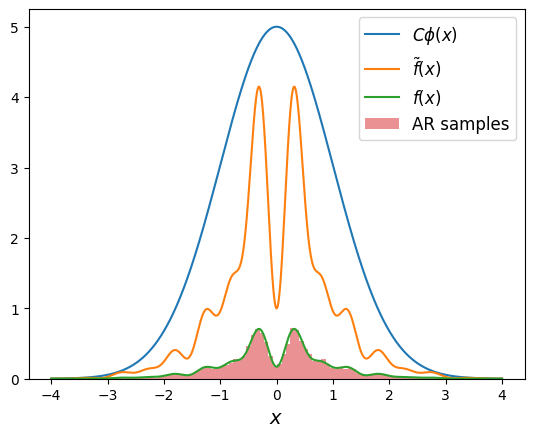

In [16]:
x = np.linspace(-4, 4, 10000)
plt.plot(x, C * norm.pdf(x), label = r'$C \phi(x)$')
plt.plot(x, f(x), label = r'$\tilde{f}(x)$')
plt.plot(x, k * f(x), label = r'$f(x)$')
plt.hist(samples, bins=100, density=True, alpha=.5, label="AR samples")

plt.xlabel("$x$", size=14)

plt.legend(fontsize=12);

The Figure down below compares the AR method's empirical CDF based on $n=10^4$ samples to that of the true CDF $F$ that is given.

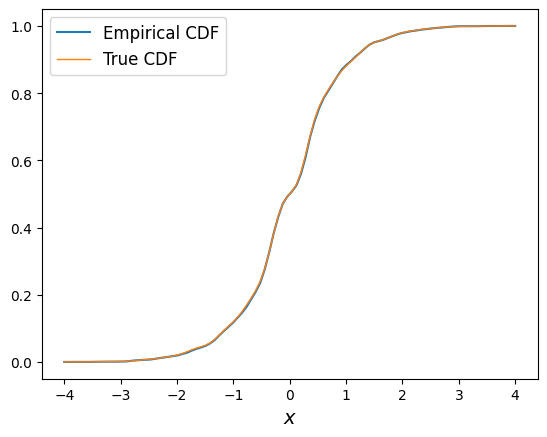

In [17]:
x = np.linspace(-4, 4, 100)

plt.plot(x, cdf(samples, x), label="Empirical CDF")
plt.plot(x, np.vectorize(CDF)(x), linewidth = 1., label = 'True CDF')

plt.xlabel("$x$", size=14)
plt.legend(fontsize=12);

## Exercise 3

An element $(x,y) \in \mathbb{R}^2$ may be represented by its polar coordinates $(\rho,\Theta) \in [0,\infty) \times [0,2\pi)$ defined by

$$
\rho(x,y) = \sqrt{x^2 + y^2},
$$
and
$$
  \Theta(x,y) = \begin{cases}
    \tan^{-1} \left({\frac{y}{x}}\right) & \text{if } x>0 \text{ and } y \ge 0,\\
    \tan^{-1} \left({\frac{y}{x}}\right) +\pi & \text{if } x<0,\\
    \tan^{-1} \left({\frac{y}{x}}\right) +2 \pi & \text{if } x>0 \text{ and } y \le 0,\\
    0 & \text{if } x=y=0,
    \end{cases}
$$

where $\tan^{-1}:\mathbb{R} \to (-\pi/2, \pi/2)$.  

1. Show by calculation that if the random variables $X,Y \sim N(0,1)$ are independent, then the polar coordinate representation of $(X,Y)$ satisfies

    $$
    \rho^2 \sim \exp(1/2) \quad \text{and} \quad \Theta \sim U([0,2\pi)).
    $$

    Show further that $\rho$ and $\Theta$ are independent.

For $X,Y \sim N(0,1)$ and independent, the joint PDF satisfies

$$
f_{X,Y}(x,y) = f_X(x)f_Y(y) = \frac{e^{-(x^2+y^2)/2}}{2\pi},
$$

due to the independence of $X$ and $Y$. Consequently,

$$
\begin{equation}\tag{1}
\begin{split}
  F_{\rho^2}(r) &= \mathbb{P}({\rho^2 \le r})\\
  &=\mathbb{P}({X^2+Y^2 \le r})\\
  &= \int_{\mathbb{R}^2} \mathbb{1}_{\{x^2+y^2 \le r\}} f_{X,Y}(x,y) dx dy\\
  &= \int_{\mathbb{R}^2} \mathbb{1}_{\{x^2+y^2 \le r\}} \frac{e^{-(x^2+y^2)/2}}{2\pi} dx dy\\
  & = \int_0^{\sqrt{r}} \int_0^{2\pi} \frac{e^{-s^2/2}}{2 \pi} s d\theta ds\\
  & = 1-e^{-r/2}\\
  &= F_{\exp(1/2)}(r).
\end{split}
\end{equation}
$$

Next, for any $\hat \theta  \in [0,2 \pi)$
  
$$
\begin{split}
F_{\Theta}(\hat \theta) &= \mathbb{P}({ \Theta(X,Y) \le \hat \theta})\\
&= \int_{\mathbb{R}^2} \mathbb{1}_{\{\Theta(x,y) \le \hat \theta\}} f_{XY}(x,y) dx dy\\
& = \int_0^{\hat \theta} \int_0^{\infty}  \frac{e^{-s^2/2}}{2 \pi} s ds d \theta \\
& = \frac{\hat \theta}{2\pi}\\
& = F_{U([0,2\pi))}(\hat \theta).
\end{split}
$$
  
To verify that $\rho^2$ and $\Theta$ are independent, note first that $(1)$ implies that $F_{\rho}(r) = 1-e^{-r^2/2}$. Furthermore, 

$$
\begin{split}
F_{\rho,\Theta}(r,\hat \theta) &= \mathbb{P}({\rho \le r, \Theta \le \hat \theta})\\
&= \int_{\mathbb{R}^2}  \mathbb{1}_{\{\sqrt{x^2+y^2} \le r\}} \mathbb{1}_{\{\Theta(x,y) \le \hat \theta\}} f_{X,Y}(x,y) dx dy\\
& = \int_0^{r} \int_0^{\hat \theta} \frac{e^{-s^2/2}}{2 \pi} s d\theta ds\\
& = \int_0^{r} e^{-s^2/2} s ds \int_0^{\hat \theta} \frac{1}{2\pi} d\theta\\
& = F_{\rho}(r) F_{\Theta}(\hat \theta).
\end{split}
$$

2. In the opposite direction, show that if $\rho^2 \sim \exp(1/2)$ and $\Theta \sim U([0,2\pi))$ and $\rho$ and $\Theta$ are independent, then the Cartesian representation of the polar coordinates $(\rho, \Theta)$,

    $$
    X = \rho \cos(2\pi \Theta) \quad \text{and} \quad Y =\rho \sin(2 \pi \Theta),
    $$

    satisfies $X,Y \sim N(0,1)$ with $X$ and $Y$ being independent.

Since $\rho$ and $\Theta$ are independent, the following holds for all $r\ge 0$ and $ \theta \in [0,2\pi)$,

$$
f_{\rho,\Theta}(r,\theta) = f_{\rho}(r) f_{\Theta}(\theta)
= \frac{d}{dr}F_{\rho}(r) \frac{d}{d \theta}F_{\Theta}(\theta) = \frac{re^{-r^2/2}}{2\pi}.
$$

To show that $X$ and $Y$ are independent standard normals, we have for any
$(\hat x,\hat y) \in \mathbb{R}^2$,

$$
\begin{split}
F_{X,Y}(\hat x,\hat y ) &= \mathbb{P}({ X \le \hat x, Y \le \hat y})\\
  & = \mathbb{P}({ \rho \cos(2\pi \Theta) \le \hat x, \rho \sin(2\pi \Theta) \le \hat y} )\\
  & = \int_0^\infty \int_{0}^{2\pi} \mathbb{1}_{\{r \cos(2\pi \theta) \le \hat x\}} \mathbb{1}_{\{r \sin(2\pi \theta) \le \hat y\}} f_{\rho,\Theta}(r,\theta)d\theta dr\\
    & = \int_0^\infty \int_{0}^{2\pi} \mathbb{1}_{\{r \cos(2\pi \theta) \le \hat x\}} \mathbb{1}_{\{r \sin(2\pi \theta) \le \hat y\}} \frac{re^{-r^2/2}}{2\pi} d\theta dr\\
    & = \int_{\mathbb{R}^2} \mathbb{1}_{\{x \le \hat x\}} \mathbb{1}_{\{y \le \hat y\}} \frac{e^{-(x^2 + y^2)/2}}{2\pi} dy dx\\
    & = \int_{-\infty}^{\hat x} \frac{e^{-x^2/2}}{\sqrt{2\pi}} dx \int_{-\infty}^{\hat y} \frac{e^{-y^2/2}}{\sqrt{2\pi}} dy\\
& = F_{N(0,1)}(\hat x) F_{N(0,1)}(\hat y).
\end{split} 
$$

Here, the fifth equality involved a change of variables $(r,\theta) \mapsto (x,y)$ from polar to Cartesian coordinates.

3. In order to construct an Acceptance-Rejection (AR) method for generating standard normal random variables consider the auxiliary PDF $g(x) = \frac{1}{2} e^{-|x|}$. For your auxiliary PDF, determine a $C\ge1$ such that
  
    $$
    \frac{e^{-x^2/2}}{\sqrt{2\pi}} \le C g(x), \qquad \forall x \in \mathbb{R}.
    $$

    **Hint:** See lecture notes for how to sample from the PDF $g$.

The smallest possible constant $C$ is given by

$$
C = \sup_{x \in \mathbb{R}}  \frac{e^{-x^2/2}}{\sqrt{2\pi} g(x)} = \sqrt{\frac{2}{\pi}} \exp\left({\sup_{x \in \mathbb{R}} -x^2/2+|x|}\right) = e^{1/2} \sqrt{\frac{2}{\pi}}.
$$


4. Implement the above AR method and the Box-Muller method and use the built-in timer function `time()` within `time` module, to compare the performance of the respective methods in terms of runtime per sample.

    **Hint:** To measure the time of your code, you can save start and end time and calculate the elapsed time using their difference:
   ```python
   start = time.time()
   # some code
   end = time.time()

   elapsed_time = end - start
   ```

For the AR method, we sample random variables $X\sim g$ from the Laplace distribution

$$
g(x) = \frac{1}{2} e^{-x} \mathbb{1}_{\{x\ge 0\}} + \frac{1}{2} e^{x} \mathbb{1}_{\{x< 0\}},
$$

by

$$
X = (2B-1)Y,\qquad B\sim \text{Bernoulli}(1/2) \text{ and } Y \sim \text{Exp}(1).
$$

The interactive plot down below shows histograms of the samples obtained with the two methods, as well as a runtime comparison.

In [18]:
def acceptance_rejection_normal(n: int) -> Tuple[np.array, float]:
    """
    Generates sequence of `n` standard normal random variables using the Acceptance-Rejection method.
    Returns the sequence as well as the acceptance rate.
    """
    C = np.exp(.5) * np.sqrt(2 / np.pi)
    g = lambda x: np.exp(-np.abs(x)) / 2
    
    accs = []
    samples = []
    while len(samples) < n:
        y = expon.rvs(size=n)
        b = bernoulli.rvs(.5, size=n)
        x_props = (2 * b - 1) * y
        
        u = uniform.rvs(size=n)
        idx = u <= norm.pdf(x_props) / g(x_props) / C
        samples.extend(x_props[idx])
        samples = samples[:n] 
        accs.append(idx.sum())
    acc = np.mean(accs) / n

    return np.array(samples), acc

In [19]:
def box_muller(n: int) -> np.array:
    """
    Generates sequence of `n` standard normal random variables using the Box-Muller method.
    """
    u = uniform.rvs(size=n)
    v = uniform.rvs(size=n)

    rho = np.sqrt(-2 * np.log(u))
    theta = 2 * np.pi * v

    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y

In [20]:
def interactive_hist_normal(n: int):
    """Interaction helper."""
    samples_ar, _ = acceptance_rejection_normal(n)
    samples_bm, _ = box_muller(n)
    
    x = np.linspace(-4, 4, 1000)
    plt.plot(x, norm.pdf(x), label="Normal PDF")
    plt.hist(samples_ar, bins=100, density=True, label="AR", alpha=.5);
    plt.hist(samples_bm, bins=100, density=True, label="BM", alpha=.5);
    plt.ylim(0, .6);
    plt.xlim(-4, 4);
    plt.xlabel("$x$", size=14)
    plt.legend(fontsize=12)

interact(interactive_hist_normal, n=(100, 10 ** 4));

interactive(children=(IntSlider(value=5050, description='n', max=10000, min=100), Output()), _dom_classes=('wi…

In [21]:
ns = np.logspace(2, 6, 10).astype(int)

reps = 10

times = np.zeros((len(ns), 2))
for i, n in tqdm(enumerate(ns)):
    
    t = 0
    for _ in range(reps):
        s = time.time()
        acceptance_rejection_normal(n)
        e = time.time()
        t += e - s
    times[i, 0] = t / reps
    
    t = 0
    for _ in range(reps):
        s = time.time()
        box_muller(n)
        e = time.time()
        t += e - s
    times[i, 1] = t / reps

0it [00:00, ?it/s]

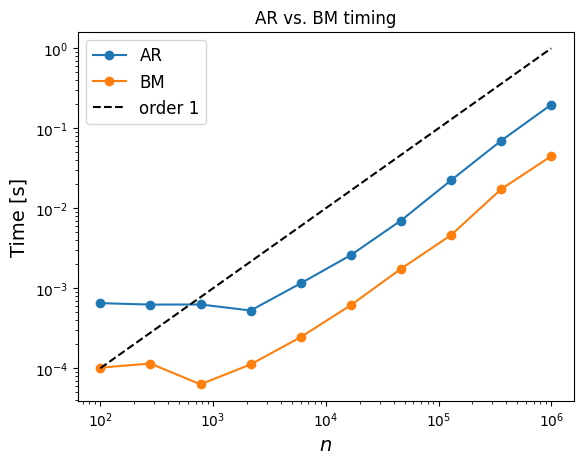

In [22]:
plt.loglog(ns, times, "o-", label=["AR", "BM"])
plt.loglog(ns, 1e-6 * ns, "k--", label="order 1")
plt.xlabel(r"$n$", size=14)
plt.ylabel("Time [s]", size=14)
plt.title("AR vs. BM timing")
plt.legend(fontsize=12);

We observe that for both methods the cost of generating $n$ samples is asymptotically $\mathcal{O}(n)$ – as one should expect – and that asymptotically the Box–Muller method is roughly **4 - 7 times** faster than the proposed AR method (in this implementation at least).

## Exercise 4

The density of a random variable $X$ may be approximated by a mixed distribution generated by so called kernel density estimation. In its simplest form, kernel density estimation consists of the following steps:

1. Choose a so called kernel function $K \in \{f: \mathbb{R} \to \mathbb{R}_+ \mid \|f\|_{L^1(\mathbb{R})} =1 \}$ (so the kernel is itself a PDF).
2. For some $n \in \mathbb{N}$, generate a sequence of i.i.d. random variables $X_1,X_2,\ldots,X_n$ from the distribution of $X$.
3. Define the kernel density estimator by

    $$
    f(x)= \frac{1}{n} \sum_{i=1}^n K_\delta(x-X_i),
    $$

    where

    $$
    K_\delta(x-X_i) := \frac{1}{\delta} K\left(\frac{x-X_i}{\delta}\right), \quad \delta >0,
    $$

    and $\delta$ is an appropriately chosen scaling parameter relating to the width of the kernel.
   
The Burr type XII distribution has the CDF

$$
F(x; \alpha,c,k) =
\begin{cases}
  0 & x \le 0\\
  1- \left(1 + \left(\frac{x}{\alpha}\right)^c \right)^{-k}, \quad x \in (0,\infty),
  & x>0,
\end{cases}
$$

with parameters $\alpha,c,k>0$.

1. Consider the Gaussian density kernel function
    $$
    K(x) = \frac{1}{\sqrt{2 \pi}} e^{-x^2/2},
    $$
    and implement a kernel density estimator for

    $$
    X \sim \text{BurrXII}(\alpha=1, c=2, k=4).
    $$

    **Hint:** Samples of $X$ can be obtained using [`scipy.stats.burr12`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.burr12.html). 

In [23]:
def kde(data: np.array, kernel: Callable, delta: Optional[float]=None) -> Callable:
    """
    Kernel density estimator for `data` using a `kernel` and optional `delta`.
    Returns a Callable.
    """
    n = len(data)
    if delta is None:
        delta = np.std(data) * n ** (-1 / 5)

    return lambda x: kernel((x - data) / delta).sum() / delta / n

In [24]:
kernel = lambda x: np.exp(-x ** 2 / 2) / np.sqrt(2 * np.pi)

2. For varying $n =[100,10^5]$ and $\delta(n) =n^{-1/5}$ compute kernel density estimators
    $$
    f_{n}(x) = \frac{1}{n} \sum_{i=1}^n K_{\delta(n)}(x-X_i),
    $$
    and plot $f_n$ and the PDF of BurrXII(1,2,4). Furthermore, for each value of $n$ sample $N=200.000$ i.i.d. random variables $Y^{n}_i \sim f_n(x)$ by means of the composition method. 

    **Hint:** The `numpy.random.randint` built-in function might come handy.

In [25]:
def plot_kde_estimation(n: int):
    """Interaction helper."""
    data = burr12(c=2, d=4).rvs(size=n)
    kde_estimator = np.vectorize(kde(data, kernel))

    x = np.linspace(0, 5, 1000)
    
    y = np.random.randint(0, high=n, size = 200_000)
    samples_kde = np.random.normal(loc=data[y], scale=np.std(data) * n ** (-1 / 5))

    plt.hist(samples_kde, bins=100, density=True, label="data", alpha=.5);
    plt.plot(x, kde_estimator(x), label="KDE")
    plt.plot(x, burr12(c=2, d=4).pdf(x), label="Burr XII")
    plt.xlim(0, 3)
    plt.ylim(0, 1.7)
    plt.xlabel("$x$", size=14)
    plt.legend(fontsize=12)

In [26]:
interact(plot_kde_estimation, n=(10**2, 10**5));

interactive(children=(IntSlider(value=50050, description='n', max=100000, min=100), Output()), _dom_classes=('…

3. Study how well the empirical CDF of $Y_{1}^{n},Y_{2}^{n}, \ldots,Y_{N}^{n}$, which we denote by $F_{n}^N(x)$, converges towards $F(x; 1,2,4)$. That is, investigate how fast

    $$
    D_n^N=\sup_{x \in [-2,5]} |F_{n}^N(x) - F(x;1,2,4)|
    $$

    decreases as $n$ increases.

In [27]:
ns = np.logspace(2, 6, 10).astype(int)

reps = 10

Dn = []
for n in ns:
    
    D = 0
    for _ in range(reps): 
        data = burr12(c=2, d=4).rvs(size=n)
        kde_estimator = np.vectorize(kde(data, kernel))

        y = np.random.randint(0, high=n, size=200_000)
        samples_kde = np.random.normal(loc=data[y], scale=np.std(data) * n ** (-1 / 5))

        x = np.linspace(-2, 5, 10000)
        true_cdf = burr12(c=2, d=4).cdf(x)

        D += np.max(np.abs(cdf(samples_kde, x) - true_cdf))
    Dn.append(D / reps)

slope, intercept, _, _, _ = linregress(np.log(ns), np.log(Dn))

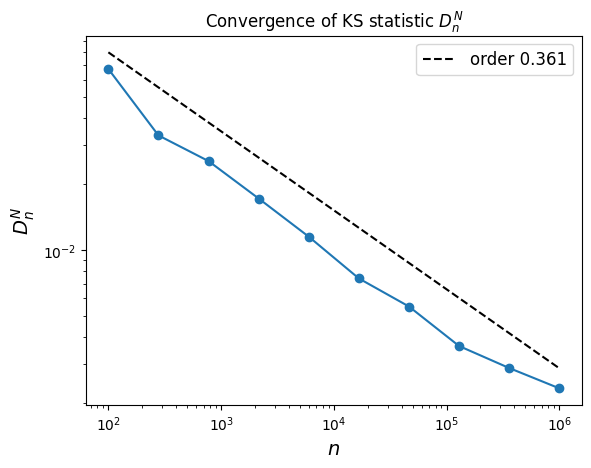

In [28]:
plt.loglog(ns, Dn, "o-")
plt.loglog(ns, 1.5 * np.exp(intercept) * ns ** slope, "k--", label=f"order {-slope:.3f}")
plt.xlabel(r"$n$", size=14)
plt.ylabel(r"$D_n^N$", size=14)
plt.title(r"Convergence of KS statistic $D_n^N$")
plt.legend(fontsize=12);

## Exercise 5

The PDF for the Cauchy distribution centered at $x_0 \in \mathbb{R}$ and with scale parameter $\gamma \in \mathbb{R}$ is given by

$$
f(x;x_0,\gamma) = \frac{1}{\pi\gamma\left(1 + \left(\frac{x-x_0}{\gamma}\right)^2\right)}.
$$

1. Show by integration of the PDF that the CDF of the Cauchy distribution with $x_0=0$ and $\gamma=1$ is given by

    $$
    F(x;0,1) = \tan^{-1}(x)\,/\,\pi +1/2,
    $$

    for $\tan^{-1}:\mathbb{R} \to (-\pi/2, \pi/2)$. 

Recalling that
$$
\frac{d}{dx} \tan^{-1}(x) = \frac{1}{1+x^2},
$$
we have for $X \sim \text{Cauchy}(0,1)$ that 
$$
F_X(x) = \mathbb{P}({X \le x}) = \int_{-\infty}^x \frac{1}{\pi(1+y^2)} dy = \left[ \frac{1}{\pi} \tan^{-1}(x) \right]_{-\infty}^x =   \frac{\tan^{-1}(x)}{\pi}  +\frac{1}{2}.
$$

2. Show that if $X_1,X_2 \sim N(0,1)$ are independent, then $X = X_1/X_2$ is Cauchy distributed with $x_0=0$ and $\gamma=1$.

For $X= X_1/X_2$ where $X_1,X_2 \sim N(0,1)$ are independent, we
make use of a Cartesian to polar coordinates transformation $(x,y) \mapsto (r, \theta)$
to show that
$$
\begin{split}
  F_X(\hat x) = \mathbb{P}({X \le \hat x})
        &= \mathbb{P}({\frac{X_1}{X_2}  \le \hat x})\\
  &= \int_{\mathbb{R}^2} \mathbb{1}_{\{y/x \le \hat x\}} \frac{e^{-(x^2+y^2)/2}}{2\pi} dx dy\\
  &= \int_{-\pi/2}^{\pi/2}  \frac{1}{\pi}\mathbb{1}_{\{\tan(\theta) \le \hat x\}} d\theta \int_0^\infty r e^{-r^2/2} dr \\
  &  = \int_{-\pi/2}^{\tan^{-1}(\hat x)}  \frac{1}{\pi} d\theta \\
  & = \frac{\tan^{-1}(\hat x)}{\pi} + \frac{1}{2}.
\end{split}
$$

3. Based on the information from exercise 5.1 and 5.2, describe and implement two algorithms for sampling $X \sim F(\cdot;0,1)$. Compare the performance of the respective algorithms in terms of runtime per sample.

The pair of sampling methods to compare is one following 5.1,
sampling $X\sim \text{Cauchy}(0,1)$ by
the inversion method with $U\sim U([0,1])$ and

$$
X = F^{-1}(U) = \tan \left(\pi\left( U-\frac{1}{2} \right)\right),
$$

and one following the ratio of Gaussians approach of 5.2.

The following Figure compares the two approaches in terms of runtime per sample. The inversion method is slightly faster than the ratio of Gaussians based method. The reason might be that while the former method only needs to generate one random variable for every ouput, the latter needs to generate two.

In [29]:
def cauchy_by_inversion(n: int) -> np.array:
    """
    Returns `n` Cauchy distributed random variables by the inversion-method.
    """
    u = uniform.rvs(size=n)
    x = np.tan(np.pi * (u - .5))
    return x

In [30]:
def cauchy_by_gauss(n:int) -> np.array:
    """
    Returns `n` Cauchy distributed random variables by the Gaussian ratio approach.
    """
    y = norm.rvs(size=(2, n))
    return y[1] / y[0]

In [31]:
ns = np.logspace(2, 6, 10).astype(int)

reps = 20

times = np.zeros((len(ns), 2))
for i, n in tqdm(enumerate(ns)):
    
    t = 0
    for _ in range(reps):
        s = time.time()
        cauchy_by_inversion(n)
        e = time.time()
        t += e - s
    times[i, 0] = t / reps
    
    t = 0
    for _ in range(reps):
        s = time.time()
        cauchy_by_gauss(n)
        e = time.time()
        t += e - s
    times[i, 1] = t / reps

0it [00:00, ?it/s]

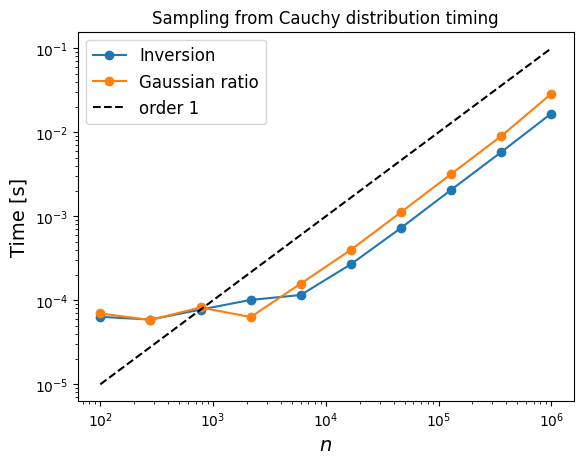

In [32]:
plt.loglog(ns, times, "o-", label=["Inversion", "Gaussian ratio"])
plt.loglog(ns, 1e-7 * ns, "k--", label="order 1")
plt.xlabel(r"$n$", size=14)
plt.ylabel("Time [s]", size=14)
plt.title("Sampling from Cauchy distribution timing")
plt.legend(fontsize=12);

4. It is possible to extend the preceding methods to sample from $X \sim F(\cdot; x_0,\gamma)$ for any $x_0 \in \mathbb{R}$ and $\gamma>0$. How? 

First generate an $X \sim \text{Cauchy}(0,1)$ with either of the above AR methods and thereafter set
$Y = \gamma(X+x_0)$. Then

$$
F_Y(y) = \mathbb{P}(Y \le y) = \mathbb{P}(X \le \frac{y-x_0}{\gamma}) = \frac{\tan^{-1} \left(\frac{y-x_0}{\gamma}\right)}{\pi}  +\frac{1}{2},
$$

and

$$
f_Y(y) = \frac{d}{dy} F_Y(y) = \frac{1}{\pi \gamma \left(1 + \left(\frac{y-x_0}{\gamma}\right)^2\right)} = f(y;x_0,\gamma).
$$

## Exercise 6 (optional, no solution)

Let $\boldsymbol{X} = (X_1,X_2,\dots,X_n)^T\sim \mathcal{U}\bigl({(0,1)}^n\bigr)$ and denote by $X_{(1)}\le X_{(2)}\le\dots\le X_{(n)}$ the ordered sample (i.e. the order statistic).

1. Implement a procedure to generate the order statistic $X_{(1)}\le X_{(2)}\le\dots\le X_{(n)}$, $n\in\mathbb{N}$, based on *sorting* a collection $\boldsymbol{X}$ of i.i.d. uniform random variables.

2. Prove the following properties:
    1. Show that
    $$
    \mathbb{P}\bigl(X_{(j)}\le  x\bigr) = \sum_{i=j}^n\binom{n}{i}x^i{(1-x)}^{n-i}\;,
    $$
        for any $x\in (0,1)$. Furthermore, use this fact to infer the distribution of the random variable $\max\{X_1,X_2,\dots,X_n\}$.
    2. Then show that
    $$
    \mathbb{P}\bigl(X_{(j)}\le  z \, \bigl\vert\bigr. \, X_{(k)}=x_k\;,\;\forall\,k>j\bigr) = {\left(\frac{z}{x_{j+1}}\right)}^{j}\;
    $$
        for all $z\le x_{j+1}$ and any $j<n$.

3. Use the facts above to implement a procedure that enables generating copies from the order statistic $X_{(1)}\le X_{(2)}\le\dots\le X_{(n)}$ *without sorting*. Compare this procedures and the procedure based on sorting with respect to time for various values of $n$. What do you observe?

4. Implement a procedure that generates uniform random vectors in the unit simplex
$$
\mathcal{S} = \Bigl\{(x_1,x_2,\dots,x_n)^T\in\mathbb{R}^n\colon x_i\ge 0\;\forall\,i\;,\;\sum_{i=1}^nx_i\le 1\Bigr\}\;.
$$
Assess your sampling procedure by visualizing $N=1000$ sampling points for $n=3$.

**Hints:**
- [3D scatter plots](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html) in Python.
- Notice that a vector, whose coordinates are distributed according to the order statistic of a collection of i.i.d. $\mathcal{U}(0,1)$, takes values in the "wedge"

    $$
    \mathcal{W}=\bigl\{(u_1,u_2,\dots,u_n)^T\in\mathbb{R}^n\colon 0\le u_i\le 1\;\forall\,i\;,\; u_1\le u_2\le\dots \le u_n\}. 
    $$
    
    The unit simplex $\mathcal{S}$ is then simply the image of the "wedge" $\mathcal{W}$ under the linear transformation $\boldsymbol{x} = A\boldsymbol{u}$ where
    
    $$
    A = \begin{pmatrix}1 & 0 &\dots & 0\\
    		-1 & 1 & \dots & 0\\
    		\vdots & \ddots & \ddots & \vdots\\
    		0 & \dots & -1 & 1\end{pmatrix}\;.
    $$